This notebook processes experimental data of tracked GAG proteins during the formation of capsids

# Define parameters

In [1]:
### Parameters

## files
trajectory_file = 'vlp.txt'

## tessellation
# cell size
resolution = .1 # in um
# minimum numbers of locations per cell
min_n  =  1 # discard below (first)
min_nn = 10 # enlarge below (second)
# time window
win   = 180. # in s
shift =  15. # in s

## inference
sigma = .03 # in um
diffusivity_smoothing = 0.
potential_smoothing   = 1.
time_smoothing        = 1e-2

## movie
frame_rate = 4 # segments per second


## automatic parameters

# files
import os.path
rwa_file = os.path.splitext(trajectory_file)[0]+'.rwa'

# label factories
seg_label = lambda n, nn, t: 'hexagon_res_{:.0f}_win_{:.0f}-{:.0f}_min_{:d}-{:d}_reg_{}'.format(round(resolution * 1e3), win, shift, n, nn, 1 if t else 0)
sdv_label = lambda t: 'sigma_{:.0f}_sdv_d_{:.0f}_v_{:.0f}_t_{:.0f}'.format(round(sigma * 1e3), diffusivity_smoothing, potential_smoothing, round(t*1e3))

# tessellate labels
for_density_label = seg_label(1, 0, 0)
for_sdv_label = seg_label(min_n, min_nn, 0)
for_smooth_sdv_label = seg_label(min_n, min_nn, 1)

# Tessellate and infer

In [19]:
from tramway.helper import *
import time

# tessellate common options
cell_sizing = dict(ref_distance=resolution, rel_avg_distance=1., min_location_count=0)
cell_adjust = dict(min_n=min_n, knn=min_nn)
time_segmentation = dict(time_window_duration=win, time_window_shift=shift)

if not os.path.exists(rwa_file):
    
    # segmentation for density estimation
    tessellate(trajectory_file, 'hexagon', output_file=rwa_file,
               **cell_sizing, # cell sizing
               **time_segmentation, # time segmentation
               output_label=for_density_label)
    
    # segmentation for dv inference without temporal smoothing
    tessellate(rwa_file, 'hexagon',
               **cell_sizing, # cell sizing
               **cell_adjust, # filter and adjust the smaller cells
               **time_segmentation, # time segmentation
               output_label=for_sdv_label)
    
    # segmentation for dv inference with temporal smoothing
    tessellate(rwa_file, 'hexagon',
               **cell_sizing, # cell sizing
               **cell_adjust, # filter and adjust the smaller cells
               **time_segmentation, enable_time_regularization=True, # time segmentation
               output_label=for_smooth_sdv_label)

# density
infer(rwa_file, 'density', input_label=for_density_label, output_label='density')

# infer common options
spatial_kwargs = dict(sigma=sigma, diffusivity_prior=diffusivity_smoothing, potential_prior=potential_smoothing)
optim_kwargs   = dict(ftol=1e-2)

# dv without temporal smoothing
t0 = time.time()
infer(rwa_file, 'stochastic.dv',
      **spatial_kwargs,
      **optim_kwargs,
      input_label=for_sdv_label, output_label=sdv_label(0))
print('elapsed time: {:d}s'.format(round(time.time()-t0)))

# dv with temporal smoothing
assert 0 < time_smoothing
t0 = time.time()
infer(rwa_file, 'stochastic.dv',
      **spatial_kwargs, time_prior=time_smoothing,
      **optim_kwargs,
      input_label=for_smooth_sdv_label, output_label=sdv_label(time_smoothing))
print('elapsed time: {:d}s'.format(round(time.time()-t0)))

/home/francois/github/TRamWAy/tramway/inference/stochastic_dv.py:157: RuntimeWarning: gradV(907) is not defined
  warn('gradV({}) is not defined'.format(i), RuntimeWarning)
/home/francois/github/TRamWAy/tramway/inference/stochastic_dv.py:157: RuntimeWarning: gradV(1672) is not defined
  warn('gradV({}) is not defined'.format(i), RuntimeWarning)
/home/francois/github/TRamWAy/tramway/inference/stochastic_dv.py:157: RuntimeWarning: gradV(142) is not defined
  warn('gradV({}) is not defined'.format(i), RuntimeWarning)
/home/francois/github/TRamWAy/tramway/inference/stochastic_dv.py:157: RuntimeWarning: gradV(13679) is not defined
  warn('gradV({}) is not defined'.format(i), RuntimeWarning)
/home/francois/github/TRamWAy/tramway/inference/stochastic_dv.py:157: RuntimeWarning: gradV(14444) is not defined
  warn('gradV({}) is not defined'.format(i), RuntimeWarning)
/home/francois/github/TRamWAy/tramway/inference/stochastic_dv.py:157: RuntimeWarning: gradV(18508) is not defined
  warn('gradV({}

elapsed time: 678s


# Create videos

In [3]:
from tramway.helper.animation import *
import os

# parameters
density_suffix =         '_n'
suffix = {'diffusivity': '_d',
          'potential':   '_v',
          'force':       '_f'}
verbose = True

# init
basename = os.path.splitext(rwa_file)[0]
movie_files = []
def grab(seg_label, map_label, feature, suffix):
    movie_file = '{}{}.mp4'.format(basename, suffix)
    movie_files.append(movie_file)
    animate_map_2d_helper(rwa_file,
                          movie_file,
                          label=[seg_label, map_label],
                          feature=feature,
                          frame_rate=frame_rate,
                          play=False, verbose=verbose)

# density
grab(for_density_label, 'density', 'density', density_suffix)

for feature in suffix:
    
    # dv without temporal smoothing
    grab(for_sdv_label, sdv_label(0), feature, suffix[feature])
    
    # dv with temporal smoothing
    _suffix = '_t{:.0f}{}'.format(round(time_smoothing*1e3), suffix[feature])
    grab(for_smooth_sdv_label, sdv_label(time_smoothing), feature, _suffix)
    
import matplotlib.pyplot
matplotlib.pyplot.close('all')
    
# movies to be opened with an external reader
print('''
In: {}
Generated files: {}'''.format(os.getcwd(), ', '.join(movie_files)))

100%|██████████| 41/41 [00:08<00:00,  5.71it/s]



In: /home/francois/github/COMPARE19/2. Gag protein
Generated files: vlp_n.mp4, vlp_d.mp4, vlp_t10_d.mp4, vlp_v.mp4, vlp_t10_v.mp4, vlp_f.mp4, vlp_t10_f.mp4


## Watch the videos

In [4]:
from IPython.display import HTML

width, height = 480, 360

# density
HTML('''
<video width="{}" height="{}" controls>
  <source src="{}" type="video/mp4">
</video>
'''.format(width, height, movie_files[0]))

In [5]:
from IPython.display import HTML

# diffusivity
HTML('''
<div style="white-space: no-wrap">
<video width="{}" height="{}" controls>
  <source src="{}" type="video/mp4">
</video>
<video width="{}" height="{}" controls>
  <source src="{}" type="video/mp4">
</video>
</div>
'''.format(width, height, movie_files[1], width, height, movie_files[4]))

# Access the inferred parameters

We are going to compare the time course of the potential energy at a selected cell.

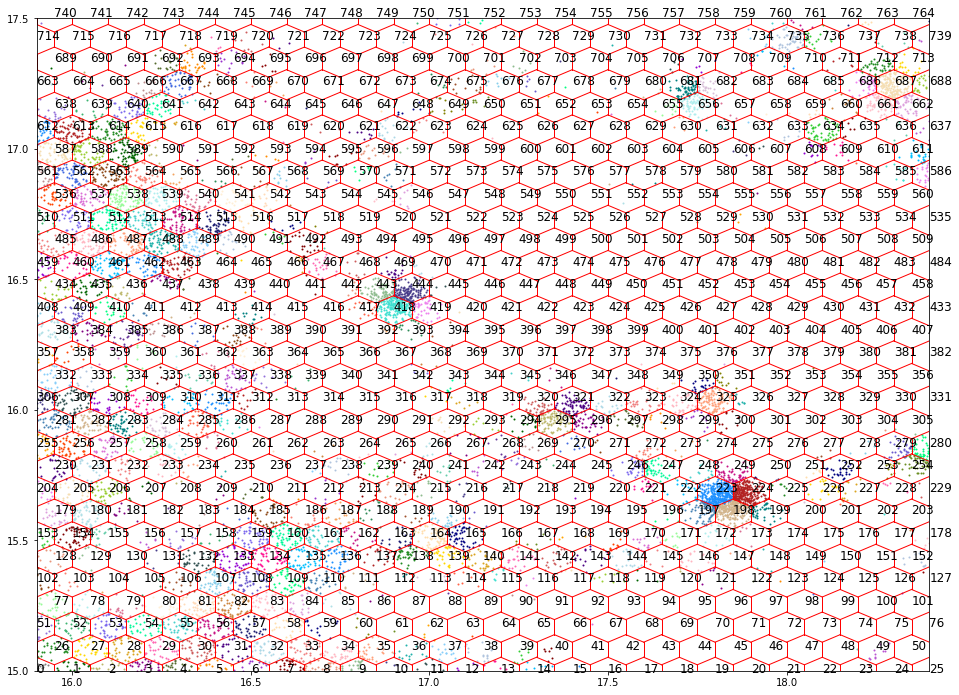

In [12]:
# load the file and pick and choose a cell
from tramway.helper import *
import matplotlib.pyplot as plt

analyses = load_rwa(rwa_file)

cell_plot(analyses, label=for_density_label, cell_indices=True, locations=dict(size=2), figsize=(16,12))

In [8]:
# imports
import numpy as np
import matplotlib.pyplot as plt

# extract the potential energy maps
cells = analyses[for_sdv_label].data

maps  = analyses[for_sdv_label][sdv_label(0)].data
V     = maps['potential']
# remember: cells are replicated for each segments and cell indices do not match those above
V

,potential
0,3.446808
1,3.446808
2,3.446808
3,3.446808
4,3.446808
5,3.446808
6,3.446808
7,3.446808
8,3.446808
9,3.446808


In [9]:
seg_V = cells.tessellation.split_frames(V, return_times=True)
# now the maps corresponding to the different time segments have adequate indices
seg_V[0][1]

,potential
0,3.446808
1,3.446808
2,3.446808
3,3.446808
4,3.446808
5,3.446808
6,3.446808
7,3.446808
8,3.446808
9,3.446808


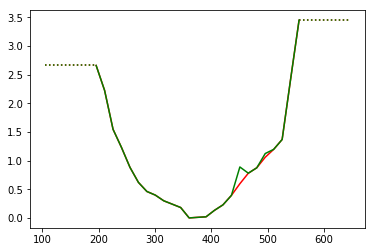

In [17]:
cell_index = 223

smooth_maps = analyses[for_smooth_sdv_label][sdv_label(time_smoothing)].data
smooth_V    = smooth_maps['potential']
smooth_V    = cells.tessellation.split_frames(smooth_V)

# complete the value extraction...
seg, t, v, smooth_v = [], [], [], []
for s in range(len(seg_V)):
    _seg, _v = seg_V[s]
    _smooth_v = smooth_V[s]
    try:
        _v = _v.loc[cell_index]
        _smooth_v = _smooth_v.loc[cell_index]
    except KeyError:
        continue
    else:
        seg.append(_seg)
        t.append((_seg[0] + _seg[1]) / 2)
        v.append(_v)
        smooth_v.append(_smooth_v)
t, v, smooth_v  = np.array(t), np.array(v), np.array(smooth_v)

# ... and plot
def plot(_v, _c):
    plt.plot([seg[0][0], t[0], None, t[-1], seg[-1][-1]], [_v[0], _v[0], None, _v[-1], _v[-1]], _c+':', linewidth=1.5)
    plt.plot(t, _v, _c+'-', linewidth=1.5)
    
plot(v, 'r')
plot(smooth_v, 'g')
plt.show()